## Import Required Libraries

In [1]:
# common libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
import helper 
import sklearn
import warnings
warnings.filterwarnings('ignore')

# machine learning libraries    

# preprocessing libraries, split data, gid search configuration, cross validation
from sklearn.model_selection import (train_test_split, 
                                    GridSearchCV, 
                                    cross_val_score, 
                                    StratifiedKFold)
# classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier   

# measurement libraries
from sklearn.datasets import make_classification
from sklearn.metrics import (confusion_matrix, 
                            ConfusionMatrixDisplay, 
                            classification_report)
from sklearn.metrics import make_scorer


## Load Data

In [2]:
# read csv file
#top_20 = pd.read_csv('../data/top_20_features.csv')
data = pd.read_csv('../data/42_features.csv')

print('Shape of dataframe prior to modeling:', data.shape)
display(data)

Shape of dataframe prior to modeling: (1269, 42)


,test_oxycodone_0,test_cocaine_0,test_methamphetamine_0,test_opiate300_0,test_oxycodone_1,test_cocaine_1,test_methamphetamine_1,test_opiate300_1,test_oxycodone_2,test_cocaine_2,...,meds_methadone_2,meds_buprenorphine_2,meds_methadone_3,meds_buprenorphine_3,meds_methadone_4,meds_buprenorphine_4,cows_predose,cows_postdose,gender,dropout
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,46.0,0.0,27.0,0.0,55.0,11,6,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,7.0,0.0,9.0,0.0,7.0,8,1,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,44.0,0.0,60.0,0.0,51.0,0.0,8,5,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,27.0,0.0,23.0,0.0,9.0,11,9,0.0,0.0
4,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11,6,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11,8,0.0,1.0
1265,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,26,10,1.0,1.0
1266,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14,6,0.0,1.0
1267,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12,5,0.0,1.0


## Split the Data to Dev and Test sets

In [3]:

# assign variables
X, y = data.drop(columns='dropout'), data['dropout']

# create the dev and test sets 
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# create the train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.15, random_state=42)

# check the shape of the train, validation, and test sets
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)



Shape of X_train: (916, 41)
Shape of X_val: (162, 41)
Shape of X_test: (191, 41)


## Review Patient Profile

In [4]:

X_train.iloc[215, :]

test_oxycodone_0             0.0
test_cocaine_0               0.0
test_methamphetamine_0       0.0
test_opiate300_0             1.0
test_oxycodone_1             0.0
test_cocaine_1               0.0
test_methamphetamine_1       0.0
test_opiate300_1             1.0
test_oxycodone_2             0.0
test_cocaine_2               0.0
test_methamphetamine_2       0.0
test_opiate300_2             1.0
test_oxycodone_3             0.0
test_cocaine_3               1.0
test_methamphetamine_3       0.0
test_opiate300_3             0.0
test_oxycodone_4             0.0
test_cocaine_4               1.0
test_methamphetamine_4       0.0
test_opiate300_4             1.0
survey_cocaine_0             1.0
survey_oxycodone_0           0.0
survey_methamphetamine_0     0.0
survey_opiates_0            30.0
survey_cocaine_4             2.0
survey_oxycodone_4           0.0
survey_methamphetamine_4     0.0
survey_opiates_4             9.0
meds_methadone_0             0.0
meds_buprenorphine_0        21.0
meds_metha

## Create Pipeline Function

In [5]:
# Import column transformer, standard scaler, one hot encoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def preprocess_data(train_df, val_df, numeric_features, categorical_features):
    """
    This function preprocesses the training, validation, and test data using the 
    column transformer, standard scaler, and one hot encoder.

    Parameters:
    train_df (DataFrame): The training data
    val_df (DataFrame): The validation data
    test_df (DataFrame): The test data
    numeric_features (list): The numeric features
    categorical_features (list): The categorical features

    Returns:
    X_train (ndarray): The preprocessed training data
    X_val (ndarray): The preprocessed validation data
    X_test (ndarray): The preprocessed test data
    preprocessor (ColumnTransformer): The column transformer object

    """
    # Define the column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )
    
    # Fit the preprocessor on the training data
    preprocessor.fit(train_df)
    
    # Transform the training, validation, and test data
    X_train = preprocessor.transform(train_df)
    X_val = preprocessor.transform(val_df)
    
    return X_train, X_val, preprocessor

In [6]:
# numeric features
numeric_features = [col for col in X_train.columns if X_train[col].dtype != 'object']
categorical_features = [col for col in X_train.columns if X_train[col].dtype == 'object']

# preprocess the data
X_train, X_val, pipeline = preprocess_data(X_train, X_val,numeric_features, categorical_features)


## Use Grid Search
We will create a reusable function to perform grid search with any classifier

In [7]:
# create custom grid search function
def perform_grid_search(X_train, y_train, X_val, y_val, classifier, hyperparams):
    """
    Perform grid search with cross-validation for a given classifier and hyperparameters.

    Parameters:
    - X_train: Training features dataframe.
    - y_train: Training target series.
    - X_val: Validation features dataframe.
    - y_val: Validation target series.
    - classifier: The classifier to use (e.g., XGBClassifier()).
    - hyperparams: Dictionary of hyperparameters to search.

    Returns:
    - results_df: Pandas DataFrame containing the results of the grid search.
    """
    # Define a custom scoring function for the C-index
    def cindex_score(y_true, y_pred):
        return helper.cindex(y_true, y_pred)

    # Wrap the custom scoring function using make_scorer
    cindex_scorer = make_scorer(cindex_score, greater_is_better=True)

    # Set up GridSearchCV with cross-validation and custom scorer
    grid_search = GridSearchCV(estimator=classifier, param_grid=hyperparams, cv=5, scoring=cindex_scorer, n_jobs=-1, verbose=1)

    # Fit GridSearchCV to the training data
    grid_search.fit(X_train, y_train)

    # Retrieve the best parameters
    best_params = grid_search.best_params_
    
    # Retrieve the best model
    best_model = grid_search.best_estimator_

    # calculate C-Index on the train set
    y_train_preds = best_model.predict_proba(X_train)[:, 1]
    c_index_train = helper.cindex(y_train.values, y_train_preds)

    # Calculate the C-index on the validation set
    y_val_preds = best_model.predict_proba(X_val)[:, 1]
    c_index = helper.cindex(y_val.values, y_val_preds)
    
    # Store the results in a DataFrame
    results = pd.DataFrame(grid_search.cv_results_)

    return results


## Define Param Grid and loop through pipelines

In [8]:
# Define the classifiers and hyperparameters

classifiers = {
    'Logistic Regression': (LogisticRegression(), {
        'C': [0.01, 0.1, 1, 10],# Regularization strength
        'penalty': ['l1', 'l2'],# Norm used in the penalization
        'solver': ['liblinear'] # Algorithm to use in the optimization problem
    }),
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [100, 200, 300],  # Number of trees in the forest
        'max_depth': [3, 5, 7, 10],  # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
        'max_features': ['auto', 'sqrt'], # Number of features to consider when looking for the best split
        'bootstrap': [True, False]        # Whether bootstrap samples are used when building trees
    }),
    'XGBoost': (XGBClassifier(), {
        'n_estimators': [100, 200, 300],    # Number of trees
        'learning_rate': [0.01, 0.1, 0.2],  # Learning rate (eta)
        'gamma': [0, 0.1, 0.2],             # Minimum loss reduction to create a new tree split
        #'lambda': [1, 1.5, 2],              # L2 regularization on leaf weights
        #'alpha': [1, 10, 100],               # L1 regularization on leaf weights
        'max_depth': [3, 5, 7],             # Maximum depth per tree
        'min_child_weight':[0, 1, 2],   # Minimum sum of instance weight (hessian) needed in a child
        'subsample': [ 0.5, 1],       # Percentage of samples used per tree
        'colsample_bytree': [0.5, 1], # Percentage of features used per tree
        'objective': ['binary:logistic'],  # Learning objective
        'eval_metric': ['error']        # Evaluation metric
    })
}

# store results in a dictionary
results = {}

# Perform grid search for each classifier
for clf_name, (clf, params) in classifiers.items():
    print(f"Running grid search for {clf_name}...")
    results[clf_name] = perform_grid_search(X_train, y_train, X_val, y_val, clf, params)
    print()


# print the best results for each classifier
for clf_name, _ in classifiers.items():
    best_cindex = results[clf_name]['mean_test_score'].max()
    best_params = results[clf_name]['params'][results[clf_name]['mean_test_score'].idxmax()]
    print(f"Best C-index for {clf_name}: {best_cindex:.4f}")
    print(f"Best hyperparameters: {best_params}")
    print()

Running grid search for Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Running grid search for Random Forest...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

Running grid search for XGBoost...
Fitting 5 folds for each of 972 candidates, totalling 4860 fits

Best C-index for Logistic Regression: 0.7312
Best hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

Best C-index for Random Forest: 0.7502
Best hyperparameters: {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}

Best C-index for XGBoost: 0.7462
Best hyperparameters: {'colsample_bytree': 0.5, 'eval_metric': 'error', 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'binary:logistic', 'subsample': 0.5}



## Run each classifier with the best params on the test set

In [28]:
# run each classifier with the best params on the test set
for clf_name, (clf, params) in classifiers.items():
    # Initialize the classifier
    clf.set_params(**results[clf_name].loc[results[clf_name]['rank_test_score'] == 1, 'params'].iloc[0])

    # Fit the classifier
    clf.fit(X_train, y_train)

    # Get the probability scores
    y_test_preds = clf.predict_proba(X_test)[:, 1]

    # Calculate the C-index
    c_index = helper.cindex(y_test.values, y_test_preds)
    print(f"{clf_name} C-index for Test Set: {c_index:.4f}")
    print()

Logistic Regression C-index for Test Set: 0.7279

Random Forest C-index for Test Set: 0.7569

XGBoost C-index for Test Set: 0.7273



## Plot Confusion Matrix

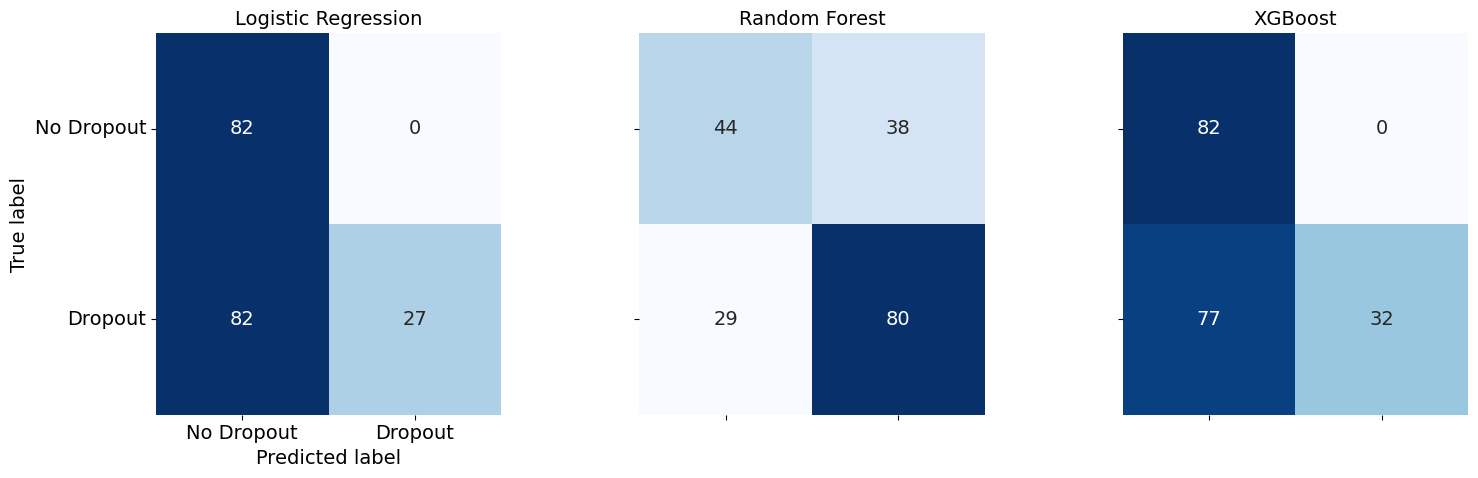

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, title, ax, fontsize=14):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, annot_kws={"size": fontsize})
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel('Predicted label', fontsize=fontsize)
    ax.set_ylabel('True label', fontsize=fontsize)
    ax.set_xticklabels(classes, fontsize=fontsize)
    ax.set_yticklabels(classes, fontsize=fontsize, rotation=0)

# Assuming y_test contains the true labels and y_test_preds contains the predicted labels
num_classifiers = len(classifiers)
fig, axes = plt.subplots(1, num_classifiers, figsize=(15, 5))  # Adjust figsize as needed

for idx, (ax, (clf_name, (clf, params))) in enumerate(zip(axes, classifiers.items())):
    # Initialize the classifier
    clf.set_params(**results[clf_name].loc[results[clf_name]['rank_test_score'] == 1, 'params'].iloc[0])

    # Fit the model
    clf.fit(X_train, y_train)

    # Get the predicted labels
    y_test_preds = clf.predict(X_test)

    # Plot confusion matrix in the respective subplot
    plot_confusion_matrix(y_test, y_test_preds, classes=['No Dropout', 'Dropout'],
                          title=f'{clf_name}', ax=ax, fontsize=14)
    
    # Remove labels for all but the first subplot
    if idx != 0:
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticklabels([])
        ax.set_yticklabels([])

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)  # Increase wspace to create more space between columns
plt.show()

In [30]:
import pandas as pd
from sklearn.metrics import classification_report

# Assuming classifiers is a dictionary of classifier names and their instances
# and results is a DataFrame containing the best parameters for each classifier

# Initialize an empty DataFrame to store the classification reports
df_classification_reports = pd.DataFrame()

for clf_name, (clf, params) in classifiers.items():
    # Initialize the classifier with the best parameters
    clf.set_params(**results[clf_name].loc[results[clf_name]['rank_test_score'] == 1, 'params'].iloc[0])

    # Fit the model
    clf.fit(X_train, y_train)

    # Get the predicted labels
    y_test_preds = clf.predict(X_test)

    # Generate the classification report
    report = classification_report(y_test, y_test_preds, output_dict=True)

    # Convert the report to a DataFrame
    report_df = pd.DataFrame(report).transpose()

    # Add a column for the classifier name
    report_df['classifier'] = clf_name

    # Append the report to the main DataFrame
    df_classification_reports = pd.concat([df_classification_reports, report_df])

# Reset the index for better readability
df_classification_reports.reset_index(inplace=True)

In [12]:
df_classification_reports

,index,precision,recall,f1-score,support,classifier
0,0.0,0.500000,1.000000,0.666667,82.000000,Logistic Regression
1,1.0,1.000000,0.247706,0.397059,109.000000,Logistic Regression
2,accuracy,0.570681,0.570681,0.570681,0.570681,Logistic Regression
3,macro avg,0.750000,0.623853,0.531863,191.000000,Logistic Regression
4,weighted avg,0.785340,0.570681,0.512807,191.000000,Logistic Regression
5,0.0,0.594937,0.573171,0.583851,82.000000,Random Forest
6,1.0,0.687500,0.706422,0.696833,109.000000,Random Forest
7,accuracy,0.649215,0.649215,0.649215,0.649215,Random Forest
8,macro avg,0.641218,0.639796,0.640342,191.000000,Random Forest
9,weighted avg,0.647761,0.649215,0.648327,191.000000,Random Forest


## Plot Feature Importance

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

def plot_feature_importance(rf_clf, feature_names, num_features=20):
    """
    Plots the feature importance for a Random Forest classifier.

    Parameters:
    rf_clf (RandomForestClassifier): The trained Random Forest classifier.
    feature_names (list): List of feature names.
    num_features (int): Number of top features to plot. Default is 20.
    """
    # Extract feature importances
    importances = rf_clf.feature_importances_
    
    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    # Sort the DataFrame by importance
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
    
    # Select the top num_features
    top_features = feature_importance_df.head(num_features)
    
    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    bars = plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
    plt.xlabel('Feature Importance (Mean Decrease in Impurity)')
    plt.ylabel('Feature')
    plt.title('Top {} Feature Importances'.format(num_features))
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
    
    # Remove the top and right border
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Annotate the bars with the importance values
    for bar in bars:
        plt.text(
            bar.get_width(), 
            bar.get_y() + bar.get_height() / 2, 
            f'{bar.get_width():.4f}', 
            va='center'
        )
    
    plt.show()

In [14]:
# create random forest classifier object

rf = (
        classifiers['Random Forest'][0]
        .set_params(**results['Random Forest']
        .loc[results['Random Forest']['rank_test_score'] == 1, 'params']
        .iloc[0])
        
        )


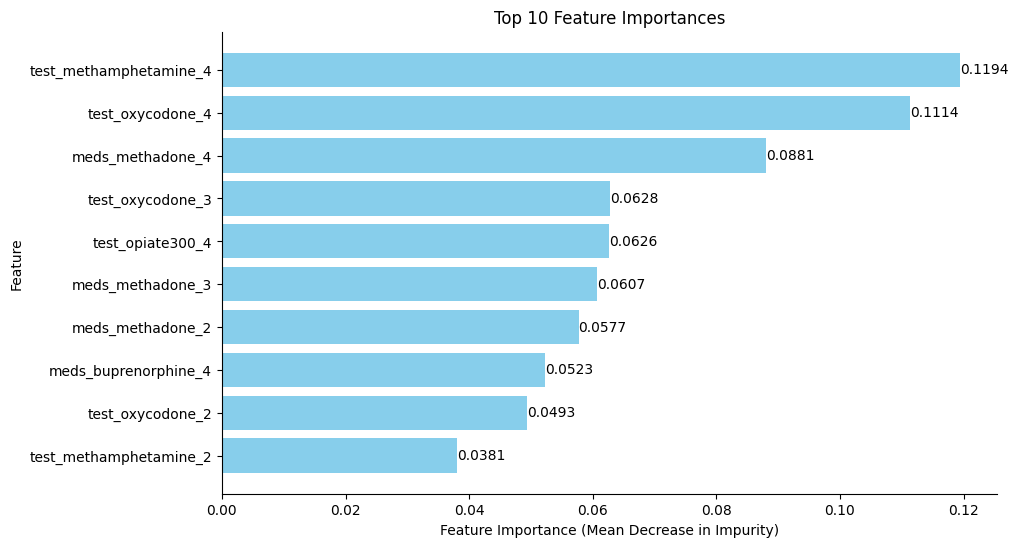

In [15]:
# plot feature importance
fi_df = plot_feature_importance(rf, X.columns, num_features=10)

In [16]:
# create classifier object
xgb = (
        classifiers['XGBoost'][0]
        .set_params(**results['XGBoost']
        .loc[results['XGBoost']['rank_test_score'] == 1, 'params']
        .iloc[0])
        )


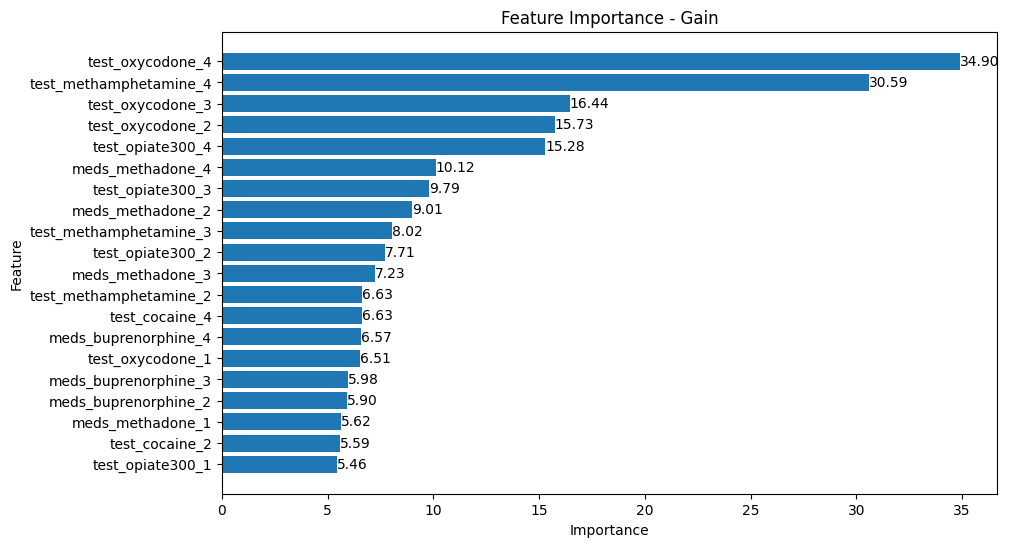

In [17]:
importance_df = helper.plot_feature_importance(xgb, pipeline, X_train, metric="gain", num_features=20)

In [18]:
list_top20 = importance_df.Feature.tolist()

top_20 = data[list_top20 + ['dropout']]

top_20.to_csv('../data/top_20_features.csv', index=False)

## Plot Decision Boundaries

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Assuming 'data' is a DataFrame and 'dropout' is the target variable
X = data[['meds_methadone_0', 'cows_postdose']]
y = data['dropout']

model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [20]:
import numpy as np

# Define the range for the grid
x_min, x_max = X['meds_methadone_0'].min() - 1, X['meds_methadone_0'].max() + 1
y_min, y_max = X['cows_postdose'].min() - 1, X['cows_postdose'].max() + 1

# Create a mesh grid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

In [21]:
# Flatten the grid to pass it to the model
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict the class for each point in the grid
Z = model.predict(grid)
Z = Z.reshape(xx.shape)

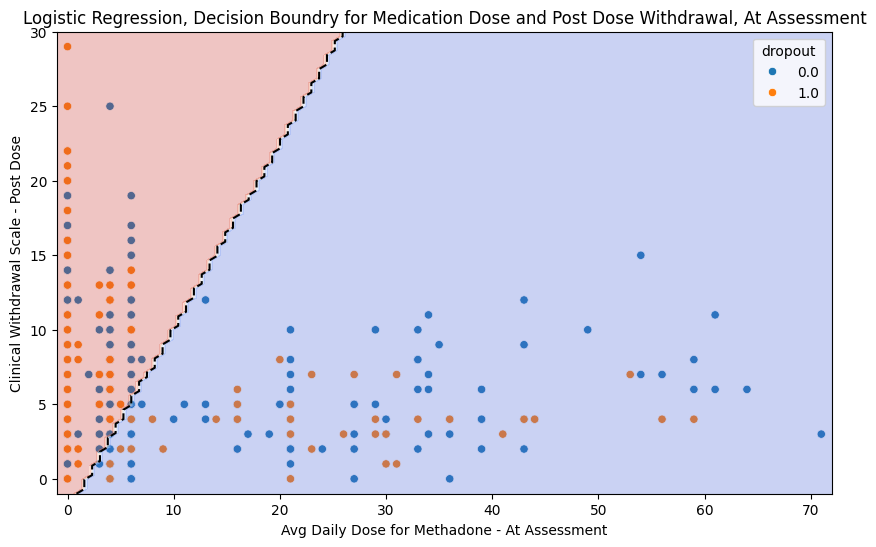

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the scatter plot
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='meds_methadone_0', y='cows_postdose', hue='dropout', data=data)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

# Plot the decision boundary line
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--')

plt.title('Logistic Regression, Decision Boundry for Medication Dose and Post Dose Withdrawal, At Assessment')
plt.xlabel('Avg Daily Dose for Methadone - At Assessment')
plt.ylabel('Clinical Withdrawal Scale - Post Dose')
# Add legend with title 'dropout'
scatter.legend(title='dropout')

plt.show()

In [23]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Assuming 'data' is a DataFrame and 'dropout' is the target variable
X = data[['meds_methadone_0', 'cows_postdose']]
y = data['dropout']

# Create a pipeline with standard scaling and XGBoost
model = make_pipeline(StandardScaler(), RandomForestClassifier())
model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [24]:
import numpy as np

# Define the range for the grid
x_min, x_max = X['meds_methadone_0'].min() - 1, X['meds_methadone_0'].max() + 1
y_min, y_max = X['cows_postdose'].min() - 1, X['cows_postdose'].max() + 1

# Create a mesh grid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

In [25]:
# Flatten the grid to pass it to the model
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict the class for each point in the grid
Z = model.predict(grid)
Z = Z.reshape(xx.shape)

Text(0, 0.5, 'Clinical Withdrawal Scale - Post Dose')

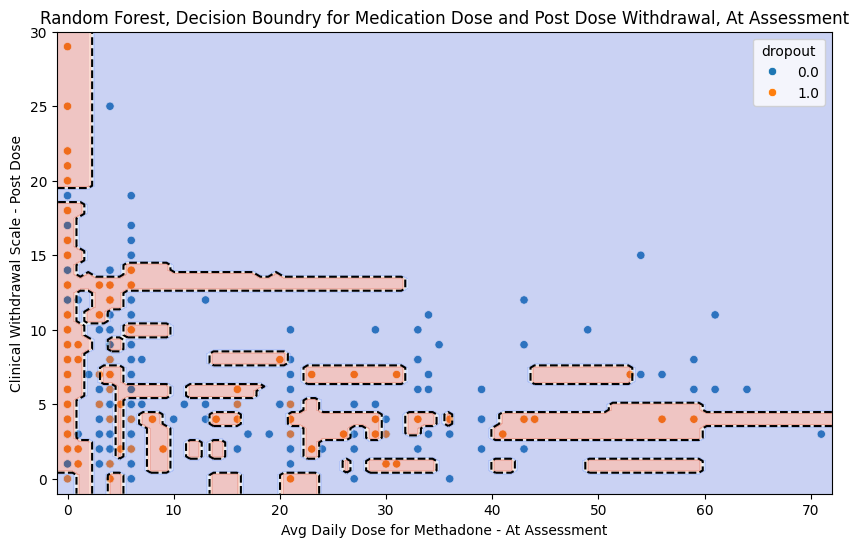

In [26]:
# Plot the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='meds_methadone_0', y='cows_postdose', hue='dropout', data=data)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

# Plot the decision boundary line
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--')

plt.title('Random Forest, Decision Boundry for Medication Dose and Post Dose Withdrawal, At Assessment')
plt.xlabel('Avg Daily Dose for Methadone - At Assessment')
plt.ylabel('Clinical Withdrawal Scale - Post Dose')

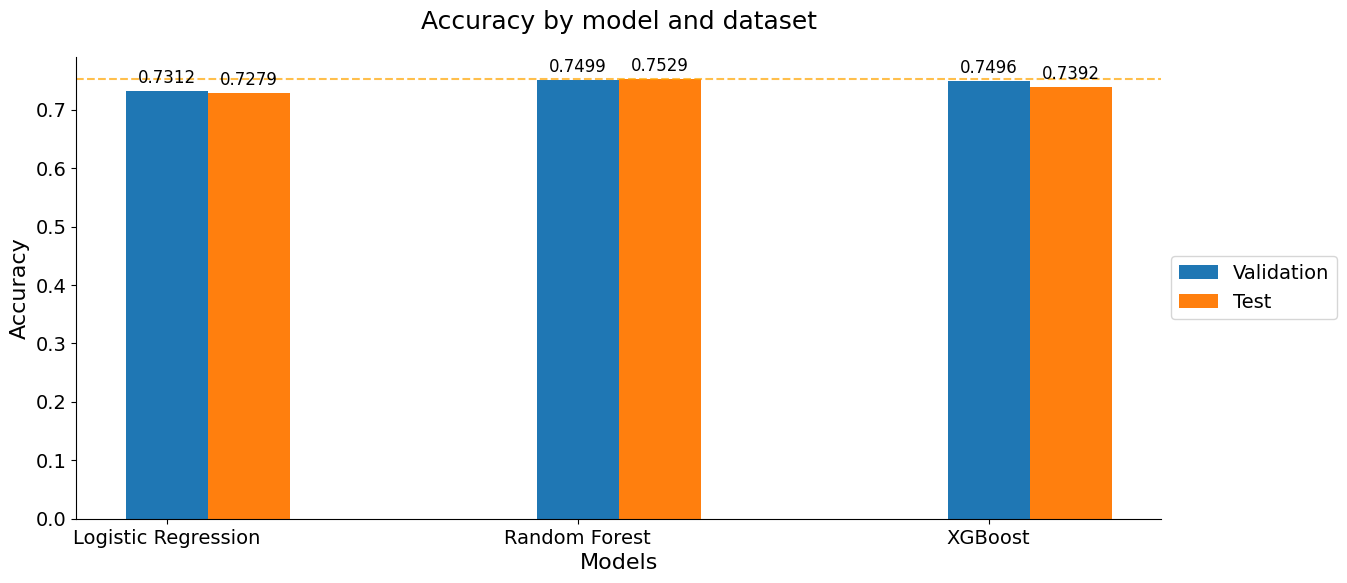

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the accuracies stored in the following dictionaries
accuracies = {
    'Logistic Regression': {
        'validation': 0.7312,
        'test': 0.7279
    },
    'Random Forest': {
        'validation': 0.7499,
        'test': 0.7529
    },
    'XGBoost': {
        'validation': 0.7496,
        'test': 0.7392
    }
}

# Extract the data
models = list(accuracies.keys())
val_accuracies = [accuracies[model]['validation'] for model in models]
test_accuracies = [accuracies[model]['test'] for model in models]

# Set up the bar plot
x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

# Set default font size
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(14, 6))
rects2 = ax.bar(x, val_accuracies, width, label='Validation')
rects3 = ax.bar(x + width, test_accuracies, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_title('Accuracy by model and dataset', fontsize=18, pad=20)  # Add padding to the title
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=14)
ax.legend(fontsize=14)

# Remove the top and right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Put legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

# Add axhline at .7524 accuracy
plt.axhline(y=.7529, color='orange', linestyle='--', alpha=0.7)

# Attach a text label above each bar in rects, displaying its height.
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12)

autolabel(rects2)
autolabel(rects3)

plt.show()